# Shrinkage estimator MC Following Ledoit and Wolf 2020


Notation: \
We denote by $|| . ||_F $ the scaled Forbenius norm of a $k \times k$ matrix $M$ defined as $||M||_F = \sqrt{\frac{1}{k} \sum\limits_{i=1}^{k}\sum\limits_{j=1}^{k}m^2_{ij}}$ \
We define: $\braket{A,A} := Tr(A'A)/k$

The scales Forbenius loss function is defined as: $\mathcal{L}(\hat{\Sigma}_N,\Sigma_N) = || \hat{\Sigma}_N - \Sigma_N ||_F^2$ \
Where $\Sigma$ denotes the var-covar matrix and $n$ is the number of observations

## 1. Linear shrinkage to a multiple of the identity

The estimator considered is a linear combination between the sample covariance matrix $S_n$ and the identity matrix of the appropriate size denotes by $\mathbb{I}_N$. The optimization problem then becomes: 
$$
\min\limits_{\rho_1, \rho_2} \mathbb{E}[|| \hat{\Sigma}_N - \Sigma_N ||_F^2] \\
s.t. \hat{\Sigma}_N = \rho_1 \mathbb{I}_N + \rho_2 S_N
$$
The solution to the optimization problem: 
$$
\Sigma^*_N = \frac{\beta^2_N}{\delta^2_N} \mu_N \mathbb{I}_N + \frac{\alpha^2_N}{\delta^2_N} S_N 
$$
Where $\mu_N := \braket{\Sigma_N,\mathbb{I}_N}$, $\alpha_N^2 := ||\Sigma_N-\mu_N \mathbb{I}_N||_F^2$, $\beta_N^2 := \mathbb{E}[||S_N-\Sigma_N||_F^2]$, and $\delta_N^2 := ||S_N -  \mu_N \mathbb{I}_N||_F^2$ 

$\Sigma_N^*$ can be rewritten as: 
$$
\Sigma^* = \gamma^* \mu_N \mathbb{I}_N + (1-\gamma^*)S_N
$$ 
where: $\gamma^* := \frac{\beta^2_N}{\delta^2_N} $ \
Interpretation: we are essentially shrinking the sample covariance matrix $S_n$ with intensity $\gamma^* \in [0,1]$ \
Intuitively the shrinkage target, that is the identity multiplied by the average of the diagonal, is a case where all covariances are zeros, and the diagonal is the average of variances. Note, mu also keeps the correct scale. If all variables are multiplied by a constant $c$, then mu is multiplied by $c^2$, which is what happens mechanically to all the elements of the covariance matrix.

We only need to estimate three parameters: $\mu_n$, $\sigma^2_N$ and $\beta^2_N$. 

Solutions:
1. We use the sample covariance matrix as an estimator, when estimating mu and delta
$$
\hat{\mu}_N := \braket{S_N,\mathbb{I}_N} = \frac{1}{k}\sum\limits_{i=1}^{k}S_{ii}^N \\
\hat{\delta}_N^2 = ||S_N - \hat{\mu}_N\mathbb{I}_N ||_F^2
$$
2. The previous strategy would not work for beta, the difference would be zero, and all of the weight would be put on the sample covariance. Instead of taking the sample covariance all at once, we sum over it line by line. Intuitively, this will reflect the bias variance tradeoff i.e. the higher the variance of of the sample covariance estimator, the more weight there would be on the shrinkage estimator. 
Denote by $x_n^N$ a $k \times 1$ vector that is the $n^{th}$ row of the data matrix. Thus we define:
$$
\widetilde{\beta}^2_N := \frac{1}{N}\sum\limits_{n=1}^N ||x_n^N \: (x_n^N)' - S_N||_F^2
$$
With $N$ being the number of observations. The estimator for beta is truncated at delta. We thus get:
$$
\hat{\beta}^2_N = \min(\widetilde{\beta}^2, \hat{\delta}_N^2)
$$
The authors note that this truncation rarely kick in in practice.

In [1]:
import MC_functions as mc
import numpy as np
import matplotlib.pyplot as plt

Use this to test the time required to run a single iteration given set parameters

In [10]:
k = 50
n = 1000
mu = 2
sigma = 10
non_zero_prob = 0.03
seed = 42

In [11]:
# Generate sparce covariance matrix
diagonal_vector, cov_matrix = mc.generate_cov_matrix(mu, sigma, k, non_zero_prob, seed)
# Generate multivariate data
data = mc. generate_multivariate_data(cov_matrix, n, seed)
# Compute the sample covariance matrix
S_mat = mc.sample_covariance_matrix(data)
# Parameter estimates
mu_parameter = mc.braket_operator_identity(S_mat)
delta_parameter = mc.scaled_f_norm(S_mat - mu_parameter * np.eye(k))**2
beta_tilde = np.sqrt(mc.f_norm_variance(data, S_mat))
beta_parameter = min(beta_tilde, delta_parameter)
gamma_star = beta_parameter/delta_parameter
# Shrinkage estimator
Sigma_star = gamma_star * mu_parameter * np.eye(k) + (1 - gamma_star) * S_mat

"As we are only interested in situations where N is of the same magnitude as T, and not in situations where N is vastly larger than T, we may assume without loss of generality that $N/K \to c \in [0, \infty)$, where $c$ is called limiting concentration (ratio)." (Ledoit and Wolf, 2020). I follow their approach and fix $c$.

In [4]:
# Set parameters for normal distribution used for the DGP
mu = 2
sigma = 2
non_zero_prob = 0.03
seed = 42

In [5]:
# Set simulation parameters
start_k = 20  # Starting value of k
step_size = 20  # Step size to increase k in each iteration
end_k = 500  # End value of k
limiting_concentration = 1.2    # Ratio of k to n
num_iterations = 100  # Number of iterations for each k

# Initialize arrays to store simulation results
biases = []
variances = []
rmse_values = []

# Loop over different values of k
for k in range(start_k, end_k + step_size, step_size):
    # Calculate n based on the given limiting concentration
    n = int(k * limiting_concentration)    # Number of observations

    # Initialize objects to store simulation results for this specific k
    bias_sum = np.zeros((k, k))
    mse_sum = np.zeros((k, k))
    estimated_cov_matrices = []

    for _ in range(num_iterations):
        # Generate sparse covariance matrix
        diagonal_vector, cov_matrix = mc.generate_cov_matrix(mu, sigma, k, non_zero_prob, seed)
        
        # Generate multivariate data
        data = mc.generate_multivariate_data(cov_matrix, n, seed)
        
        # Compute the sample covariance matrix
        S_mat = mc.sample_covariance_matrix(data)
        
        # Parameter estimates
        mu_parameter = mc.braket_operator_identity(S_mat)
        delta_parameter = mc.scaled_f_norm(S_mat - mu_parameter * np.eye(k))**2
        beta_tilde = mc.f_norm_variance(data, S_mat)
        beta_parameter = min(beta_tilde, delta_parameter)
        gamma_star = beta_parameter/delta_parameter
        
        # Shrinkage estimator
        Sigma_star = gamma_star * mu_parameter * np.eye(k) + (1 - gamma_star) * S_mat
        
        # Calculate bias, RMSE, and variance
        true_cov_matrix = cov_matrix
        estimated_cov_matrix = Sigma_star

        # Calculate bias and accumulate
        bias = true_cov_matrix - estimated_cov_matrix
        bias_sum += bias
        mse = bias ** 2
        mse_sum += mse

        # Save estimated covariance matrix
        estimated_cov_matrices.append(estimated_cov_matrix)
        
    # Calculate average bias and variance for this specific k
    k_bias_mat = bias_sum / num_iterations
    average_k_bias = np.mean(k_bias_mat)
    stacked_matrices = np.stack(estimated_cov_matrices, axis=0)
    k_variance_mat = np.var(stacked_matrices, axis=0)
    average_k_variance = np.mean(k_variance_mat)

    # Calculate MSE for each element of the covariance matrix
    k_mse = mse_sum / num_iterations
    rmse = np.sqrt(mse)
    rmse_values.append(rmse)
    
    # Store average and standard deviation for this specific k
    biases.append(average_k_bias)
    variances.append(average_k_variance)
    rmse_values.append(rmse)


KeyboardInterrupt: 

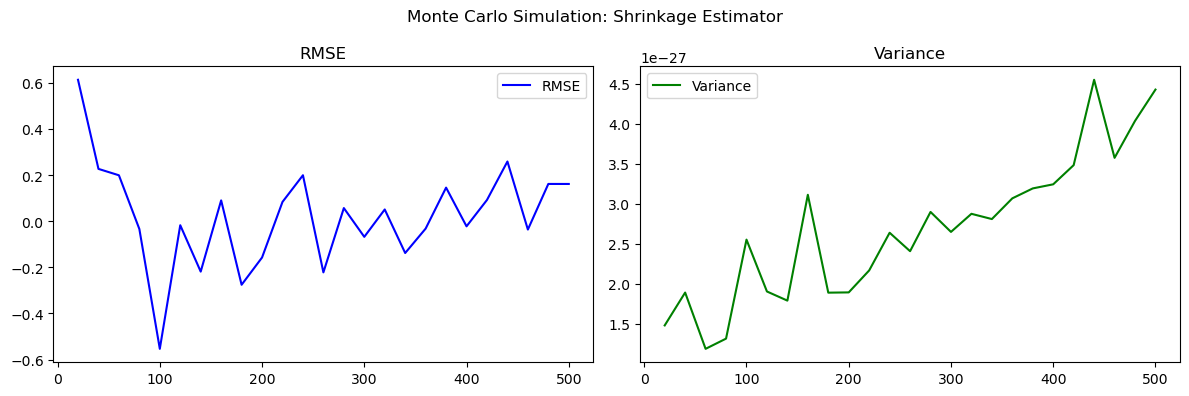

In [70]:
# Create a figure and three subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot bias in the first subplot
axs[0].plot(range(start_k, end_k + step_size, step_size), biases, label='RMSE', color='blue')
axs[0].set_title('RMSE')
axs[0].legend()

# Plot variance in the second subplot
axs[1].plot(range(start_k, end_k + step_size, step_size), variances, label='Variance', color='green')
axs[1].set_title('Variance')
axs[1].legend()

# Add a title to the whole plot
plt.suptitle('Monte Carlo Simulation: Shrinkage Estimator')

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show()

Unfortunately, in this more general setting, we had not been able to derive a consistent estimator under large-dimensional asymptotics and, therefore, had to settle for standard (or traditional) asymptotics where N remains fixed and only T tends to infinity (Ledoit and Wolf, 2020). Following this, I re-run the simulation with a fixed N and increasing T (referes to the number of variables, which is denoted as k in the code). The results are shown in the following figure.

In [71]:
# Set simulation parameters
start_k = 20  # Starting value of k
step_size = 20  # Step size to increase k in each iteration
end_k = 500  # End value of k
num_iterations = 100  # Number of iterations for each k

# Initialize arrays to store simulation results
biases = []
variances = []
rmse_values = []

# Loop over different values of k
for k in range(start_k, end_k + step_size, step_size):
    # Calculate n based on the given limiting concentration
    n = 1000

    # Initialize objects to store simulation results for this specific k
    bias_sum = np.zeros((k, k))
    mse_sum = np.zeros((k, k))
    estimated_cov_matrices = []

    for _ in range(num_iterations):
        # Generate sparse covariance matrix
        diagonal_vector, cov_matrix = mc.generate_cov_matrix(mu, sigma, k, non_zero_prob, seed)
        
        # Generate multivariate data
        data = mc.generate_multivariate_data(cov_matrix, n, seed)
        
        # Compute the sample covariance matrix
        S_mat = mc.sample_covariance_matrix(data)
        
        # Parameter estimates
        mu_parameter = mc.braket_operator_identity(S_mat)
        delta_parameter = mc.scaled_f_norm(S_mat - mu_parameter * np.eye(k))**2
        beta_tilde = mc.f_norm_variance(S_mat)
        beta_parameter = min(beta_tilde, delta_parameter)
        gamma_star = beta_parameter/delta_parameter
        
        # Shrinkage estimator
        Sigma_star = gamma_star * mu_parameter * np.eye(k) + (1 - gamma_star) * S_mat
        
        # Calculate bias, RMSE, and variance
        true_cov_matrix = cov_matrix
        estimated_cov_matrix = Sigma_star

        # Calculate bias and accumulate
        bias = true_cov_matrix - estimated_cov_matrix
        bias_sum += bias
        mse = bias ** 2
        mse_sum += mse

        # Save estimated covariance matrix
        estimated_cov_matrices.append(estimated_cov_matrix)
        
    # Calculate average bias and variance for this specific k
    k_bias_mat = bias_sum / num_iterations
    average_k_bias = np.mean(k_bias_mat)
    stacked_matrices = np.stack(estimated_cov_matrices, axis=0)
    k_variance_mat = np.var(stacked_matrices, axis=0)
    average_k_variance = np.mean(k_variance_mat)

    # Calculate MSE for each element of the covariance matrix
    k_mse = mse_sum / num_iterations
    rmse = np.sqrt(mse)
    rmse_values.append(rmse)
    
    # Store average and standard deviation for this specific k
    biases.append(average_k_bias)
    variances.append(average_k_variance)
    rmse_values.append(rmse)

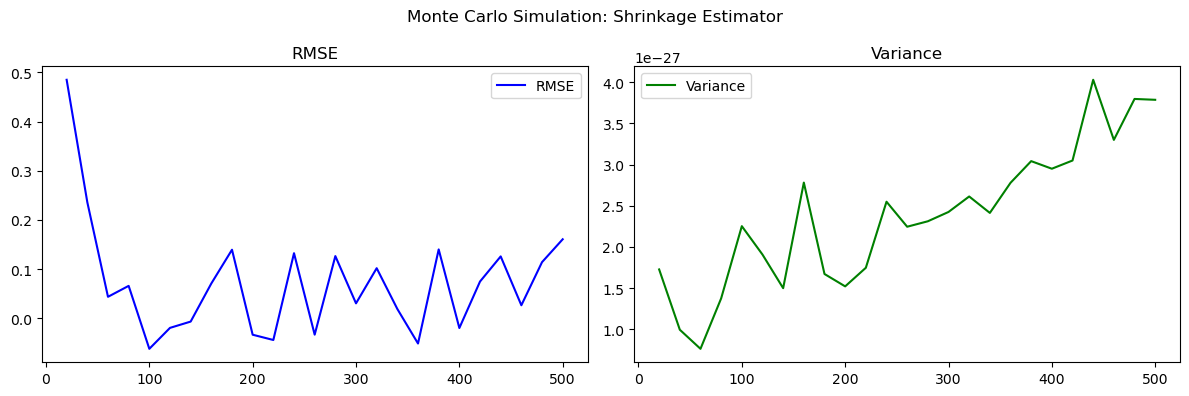

In [72]:
# Create a figure and three subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot bias in the first subplot
axs[0].plot(range(start_k, end_k + step_size, step_size), biases, label='RMSE', color='blue')
axs[0].set_title('RMSE')
axs[0].legend()

# Plot variance in the second subplot
axs[1].plot(range(start_k, end_k + step_size, step_size), variances, label='Variance', color='green')
axs[1].set_title('Variance')
axs[1].legend()

# Add a title to the whole plot
plt.suptitle('Monte Carlo Simulation: Shrinkage Estimator')

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show()

## 2. Linear shrinkage to a custom tailored target

Same Procedure, but a different shrinkage target. Works better for finance applications.

## 3. Non-linear shrinkage 

Generalization: use different shrinkage intensities for different sample eigenvalues